# Lab 5: Convolutions, Pooling, and Simple CNNs
This notebook walks through: (1) manual convolution on a 5×5 input, (2) pooling operations, (3) visualizing flattened pooled features, (4) learning a tiny linear model on those features, and (5) simple CNN definitions for MNIST and CIFAR-10.

## Q1. Convolution on a 5×5 input with a 3×3 kernel (stride 1 and 2)
- We use the deep learning convention (cross-correlation: no kernel flip).
- Convolution is computed in 'valid' mode (no padding).

In [1]:
# Imports and helper functions
import numpy as np
import matplotlib.pyplot as plt

def conv2d_valid(x: np.ndarray, k: np.ndarray, stride: int = 1) -> np.ndarray:
    """2D cross-correlation (no kernel flip), valid mode, integer stride."""
    k_h, k_w = k.shape
    x_h, x_w = x.shape
    out_h = (x_h - k_h) // stride + 1
    out_w = (x_w - k_w) // stride + 1
    out = np.zeros((out_h, out_w), dtype=float)
    for i in range(out_h):
        for j in range(out_w):
            region = x[i*stride:i*stride + k_h, j*stride:j*stride + k_w]
            out[i, j] = np.sum(region * k)
    return out

def pool2d(x: np.ndarray, size: int = 2, stride: int = 1, mode: str = 'max') -> np.ndarray:
    """2D pooling with a square window of `size` and integer stride."""
    x_h, x_w = x.shape
    out_h = (x_h - size) // stride + 1
    out_w = (x_w - size) // stride + 1
    out = np.zeros((out_h, out_w), dtype=float)
    for i in range(out_h):
        for j in range(out_w):
            region = x[i*stride:i*stride + size, j*stride:j*stride + size]
            if mode == 'max':
                out[i, j] = np.max(region)
            elif mode == 'avg':
                out[i, j] = np.mean(region)
            elif mode == 'sum':
                out[i, j] = np.sum(region)
            else:
                raise ValueError("Unknown pooling mode: " + str(mode))
    return out

In [2]:
# Define input and kernel (as provided)
X = np.array([[1, 0, 1, 1, 0],
              [0, 0, 0, 1, 1],
              [1, 0, 0, 0, 1],
              [0, 1, 1, 1, 0],
              [1, 1, 0, 1, 0]], dtype=float)

K = np.array([[1, 0, 0],
              [0, 0, 1],
              [1, 1, 0]], dtype=float)

Y_stride1 = conv2d_valid(X, K, stride=1)
Y_stride2 = conv2d_valid(X, K, stride=2)

{
    'stride_1_output': Y_stride1,
    'stride_2_output': Y_stride2,
}

{'stride_1_output': array([[2., 1., 2.],
        [1., 2., 3.],
        [4., 2., 1.]]),
 'stride_2_output': array([[2., 2.],
        [4., 1.]])}

## Q2. Apply max/avg/sum pooling to the above convolution results
- Pooling window: 2×2
- Stride: 1
- Modes: max, average, sum

In [3]:
pooled = {}
for s_name, Y in [('stride_1', Y_stride1), ('stride_2', Y_stride2)]:
    pooled[f'{s_name}_max'] = pool2d(Y, size=2, stride=1, mode='max')
    pooled[f'{s_name}_avg'] = pool2d(Y, size=2, stride=1, mode='avg')
    pooled[f'{s_name}_sum'] = pool2d(Y, size=2, stride=1, mode='sum')

pooled

{'stride_1_max': array([[2., 3.],
        [4., 3.]]),
 'stride_1_avg': array([[1.5 , 2.  ],
        [2.25, 2.  ]]),
 'stride_1_sum': array([[6., 8.],
        [9., 8.]]),
 'stride_2_max': array([[4.]]),
 'stride_2_avg': array([[2.25]]),
 'stride_2_sum': array([[9.]])}

## Q3. Visualize flattened pooled feature maps
We flatten each pooled map. Because their lengths may differ, we zero-pad them to the same length for side-by-side visualization. Bar charts show the values of each flattened vector.

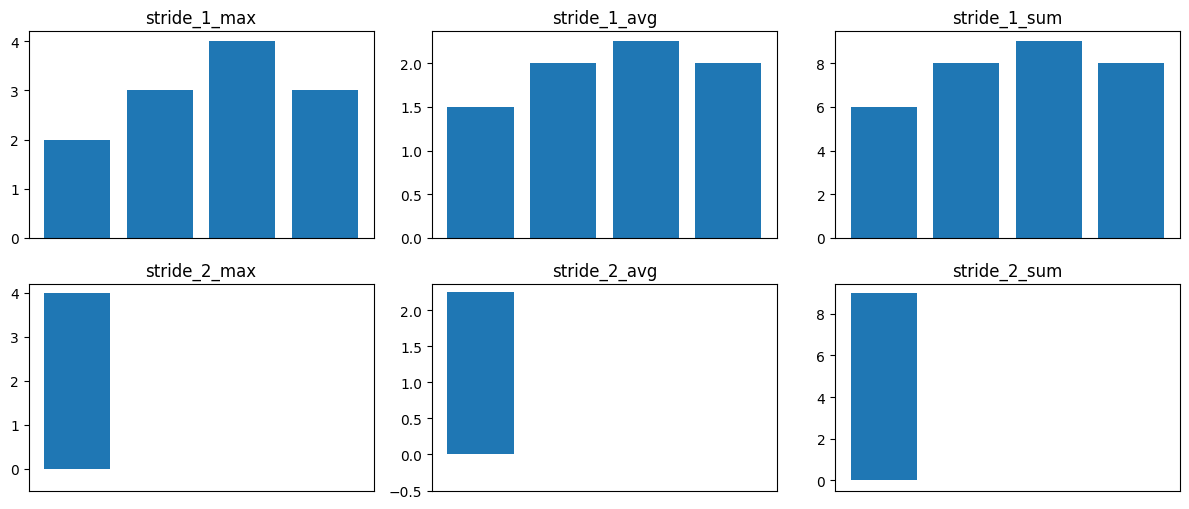

In [4]:
# Flatten, pad to equal length, and visualize
flattened = {name: arr.reshape(-1) for name, arr in pooled.items()}
max_len = max(v.size for v in flattened.values())

def pad1d(v: np.ndarray, L: int) -> np.ndarray:
    if v.size == L:
        return v
    return np.pad(v, (0, L - v.size), mode='constant')

X_flat = {name: pad1d(vec, max_len) for name, vec in flattened.items()}

n = len(X_flat)
cols = 3
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 2.6))
axes = axes.ravel()
for ax, (name, vec) in zip(axes, X_flat.items()):
    ax.bar(np.arange(len(vec)), vec)
    ax.set_title(name)
    ax.set_xticks([])
    ax.set_ylim(bottom=min(0, np.min(vec) - 0.5))
# Remove any unused subplots
for k in range(len(X_flat), len(axes)):
    fig.delaxes(axes[k])
fig.tight_layout()

## Q4. Learn weights and bias over 1 epoch on flattened arrays
- Dataset: the flattened vectors from Q3 (zero-padded to equal length).
- Target (for simplicity): y = sum of features (regression).
- Model: single linear neuron; init weights random, bias = 1. Optimize with SGD for 1 epoch.

In [5]:
# Build tiny dataset from the flattened vectors
names = list(X_flat.keys())
X_ds = np.stack([X_flat[n] for n in names], axis=0)
y = X_ds.sum(axis=1)  # simple regression target

# Initialize parameters
np.random.seed(0)
w = np.random.randn(X_ds.shape[1])
b = 1.0
lr = 0.1

# One epoch of SGD
for i in range(X_ds.shape[0]):
    x_i = X_ds[i]
    pred = x_i.dot(w) + b
    err = pred - y[i]
    w -= lr * 2.0 * err * x_i
    b -= lr * 2.0 * err

# Report final loss and parameters
preds = X_ds.dot(w) + b
final_loss = np.mean((preds - y) ** 2)
{'weights': w, 'bias': float(b), 'final_loss': float(final_loss)}

{'weights': array([1092.1116848 , -243.68430392, -274.16205676, -241.84356792]),
 'bias': 36.99592840027644,
 'final_loss': 20485120.76716925}